In [ ]:
# Install necessary libraries
!pip install tensorflow numpy matplotlib seaborn scikit-learn

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

# Paths
source_folder = "/content/drive/MyDrive/TB DATA /Manual_Test"  # Replace with the folder containing the images
destination_folder = "/content/drive/MyDrive/TB DATA /Main_data"  # The Main_data folder

# Iterate over each class folder
for class_folder in os.listdir(source_folder):
    source_class_path = os.path.join(source_folder, class_folder)
    destination_class_path = os.path.join(destination_folder, class_folder)

    if not os.path.exists(destination_class_path):
        os.makedirs(destination_class_path)  # Ensure destination class folder exists

    for file_name in os.listdir(source_class_path):
        source_file = os.path.join(source_class_path, file_name)
        destination_file = os.path.join(destination_class_path, file_name)

        if os.path.isfile(source_file):
            shutil.move(source_file, destination_file)
            print(f"Moved: {file_name} to {class_folder}")

print("Images have been restored to the Main_data directory.")


Moved: tb_1.jpg to TB
Moved: tb_19.jpg to TB
Moved: tb_32.jpg to TB
Moved: tb_62.jpg to TB
Moved: tb_72.jpg to TB
Moved: tb_77.jpg to TB
Moved: tb_82.jpg to TB
Moved: tb_84.jpg to TB
Moved: tb_85.jpg to TB
Moved: tb_86.jpg to TB
Moved: tb_96.jpg to TB
Moved: tb_101.jpg to TB
Moved: tb_102.jpg to TB
Moved: tb_106.jpg to TB
Moved: tb_113.jpg to TB
Moved: tb_114.jpg to TB
Moved: tb_121.jpg to TB
Moved: tb_124.jpg to TB
Moved: tb_131.jpg to TB
Moved: tb_133.jpg to TB
Moved: tb_137.jpg to TB
Moved: tb_141.jpg to TB
Moved: tb_149.jpg to TB
Moved: tb_157.jpg to TB
Moved: tb_158.jpg to TB
Moved: tb_168.jpg to TB
Moved: tb_170.jpg to TB
Moved: tb_173.jpg to TB
Moved: tb_177.jpg to TB
Moved: tb_183.jpg to TB
Moved: tb_203.jpg to TB
Moved: tb_227.jpg to TB
Moved: tb_233.jpg to TB
Moved: tb_241.jpg to TB
Moved: tb_244.jpg to TB
Moved: tb_250.jpg to TB
Moved: tb_251.jpg to TB
Moved: tb_252.jpg to TB
Moved: tb_254.jpg to TB
Moved: tb_262.jpg to TB
Moved: tb_264.jpg to TB
Moved: tb_265.jpg to TB
Move

In [ ]:
import os

# Path to Main_data directory
main_dir = '/content/drive/MyDrive/TB DATA /Main_data'

# Count number of images across all class folders
total_images = sum(len(files) for _, _, files in os.walk(main_dir))

print(f"✅ Total images in Main_data: {total_images}")


✅ Total images in Main_data: 11701


In [ ]:
import os
import shutil
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Dataset Paths**
train_dir = "/content/drive/MyDrive/TB DATA /Main_data"  # Full dataset
test_dir = "/content/drive/MyDrive/TB DATA /Manual_Test"  # Test dataset

# **Ensure Test Directory Exists**
os.makedirs(test_dir, exist_ok=True)

# **Move 15% of Data to Test Set**
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    test_class_path = os.path.join(test_dir, class_name)
    os.makedirs(test_class_path, exist_ok=True)

    images = os.listdir(class_path)
    if len(images) == 0:
        print(f"Skipping empty class: {class_name}")
        continue

    # **Move 15% of images for the test set**
    test_images = random.sample(images, max(1, int(0.15 * len(images))))
    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_class_path, img))

print("✅ Test dataset created and images moved.")

# **Verify Remaining Images in `Main_data`**
total_remaining = sum(len(os.listdir(os.path.join(train_dir, class_name))) for class_name in os.listdir(train_dir))
print(f"✅ Remaining images in Main_data after test split: {total_remaining}")

# **Split the Remaining Data into Training (80%) and Validation (20%)**
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)

    if len(images) < 5:
        print(f"Skipping small class: {class_name}")
        continue

    class_train, class_val = train_test_split(images, test_size=0.2, random_state=42)

    train_images = len(class_train)
    val_images = len(class_val)

    print(f"✅ Training images for {class_name}: {train_images}, Validation images: {val_images}")

print("✅ Final dataset split completed.")

# **Data Augmentation & Preprocessing**
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values (0-1 range)
    rotation_range=30,             # Improve generalization
    zoom_range=0.2,                # Random zoom variation
    horizontal_flip=True,           # Flip images randomly
    brightness_range=[0.7, 1.3],    # Adjust brightness robustness
    shear_range=0.3,                # Random shearing distortions
    width_shift_range=0.2,          # Shift images left/right
    height_shift_range=0.2,         # Shift images up/down
    fill_mode='nearest',            # Handles missing pixels after transformations
    validation_split=0.2             # Ensures correct 80% train / 20% validation split
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation & test

# **Load Training Data (80% of Main Data)**
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# **Load Validation Data (20%)**
val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# **Load Test Data (Fixed Dataset)**
test_data = val_test_datagen.flow_from_directory(
    test_dir,  # Test folder
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

# **Final Dataset Summary**
print(f"✅ Final Training samples: {train_data.samples}")
print(f"✅ Final Validation samples: {val_data.samples}")
print(f"✅ Final Test samples: {test_data.samples}")


✅ Test dataset created and images moved.
✅ Remaining images in Main_data after test split: 9947
✅ Training images for TB: 476, Validation images: 119
✅ Training images for COVID: 2459, Validation images: 615
✅ Training images for Pneumonia: 2635, Validation images: 659
✅ Training images for Normal: 2387, Validation images: 597
✅ Final dataset split completed.
Found 7960 images belonging to 4 classes.
Found 1987 images belonging to 4 classes.
Found 1754 images belonging to 4 classes.
✅ Final Training samples: 7960
✅ Final Validation samples: 1987
✅ Final Test samples: 1754


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# **Dataset Paths**
train_dir = "/content/drive/MyDrive/TB DATA /Main_data"
test_dir = "/content/drive/MyDrive/TB DATA /Manual_Test"

# **Minimal Augmentation for Faster Processing**
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train / 20% validation split
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation/test

# **Load Training Data (Smaller Batch Size for Testing Speed)**
train_data_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="training", shuffle=True
)

# **Load Validation Data**
val_data_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", subset="validation", shuffle=False
)

# **Load Test Data**
test_data_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# **Compute Class Weights (Ultra-Light Processing)**
class_labels = []
num_batches = min(10, train_data_gen.samples // train_data_gen.batch_size)  # Sample only 10 batches

for i in range(num_batches):
    images, labels = next(train_data_gen)  # Get next batch
    class_labels.extend(np.argmax(labels, axis=-1))  # Convert one-hot labels to class indices

class_labels = np.array(class_labels)

# **Compute Balanced Class Weights**
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))

print(f"✅ Optimized Class Weights: {class_weights}")

# **Final Dataset Summary**
print(f"✅ Training samples: {train_data_gen.samples}")
print(f"✅ Validation samples: {val_data_gen.samples}")
print(f"✅ Test samples: {test_data_gen.samples}")


Found 7960 images belonging to 4 classes.
Found 1987 images belonging to 4 classes.
Found 1754 images belonging to 4 classes.
✅ Optimized Class Weights: {0: np.float64(0.8080808080808081), 1: np.float64(0.9090909090909091), 2: np.float64(0.7339449541284404), 3: np.float64(3.3333333333333335)}
✅ Training samples: 7960
✅ Validation samples: 1987
✅ Test samples: 1754


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2

# **Explicit Input Layer**
input_layer = Input(shape=(224, 224, 3))

# **Load Pretrained ResNet-50 Base Model**
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=input_layer)

# **Fine-Tuning: Unfreeze Last 30 Layers for Task-Specific Learning**
for layer in base_model.layers[:-30]:  # Unfreeze last 30 layers
    layer.trainable = False

# **Custom Layers on Top**
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)  # **L2 Regularization Applied**
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # **Higher dropout for regularization**
output = Dense(4, activation="softmax")(x)  # Modify based on number of classes

# **Define Full Model**
model = Model(inputs=input_layer, outputs=output)

# **Compile Model with Optimized Learning Rate**
optimizer = AdamW(learning_rate=1e-4, amsgrad=True)  # **AdamW improves stability**
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# **Model Summary**
model.summary()
print("✅ Optimized model architecture applied.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,649,092 (94.03 MB)

 Trainable params: 15,506,436 (59.15 MB)

 Non-trainable params: 9,142,656 (34.88 MB)

✅ Optimized model architecture applied.


In [ ]:
# Save the model to a Google Drive directory
model.save('final_model.keras')



✅ XLA Compilation enabled for faster execution.
✅ Model complexity optimized by reducing fine-tuning depth.
Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7525 - loss: 1.6700
Epoch 1: val_accuracy improved from -inf to 0.45898, saving model to best_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 1571s 6s/step - accuracy: 0.7527 - loss: 1.6695 - val_accuracy: 0.4590 - val_loss: 1.8479 - learning_rate: 1.0000e-04
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8504 - loss: 1.2824
Epoch 2: val_accuracy improved from 0.45898 to 0.73528, saving model to best_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 101s 400ms/step - accuracy: 0.8504 - loss: 1.2823 - val_accuracy: 0.7353 - val_loss: 1.5067 - learning_rate: 1.0000e-04
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8664 - loss: 1.1813
Epoch 3: val_accuracy improved from 0.73528 to 0.73729, saving model to best_model.keras
249/249 ━━━━━━━━━━━━━━━━━━━━ 95s 379ms/step - accuracy: 0.8664 - loss: 

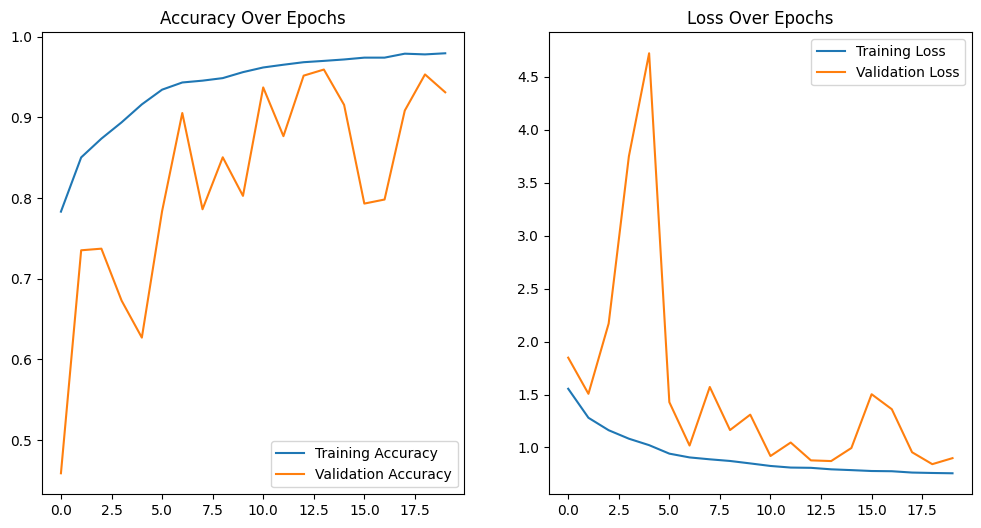

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# **Enable Mixed Precision for Faster Training**
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# **Enable XLA Compilation**
tf.config.optimizer.set_jit(True)
print("✅ XLA Compilation enabled for faster execution.")

# **Reduce Model Complexity: Fine-Tune Last 30 Layers Instead of 50**
for layer in base_model.layers[:-30]:  # Unfreeze last 30 layers for better efficiency
    layer.trainable = False

print("✅ Model complexity optimized by reducing fine-tuning depth.")

# **Training Callbacks**
checkpoint = ModelCheckpoint(
    "best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# **Start Training**
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=20,
    class_weight=class_weights,
    steps_per_epoch=len(train_data_gen),  # Ensures correct batch iteration
    validation_steps=len(val_data_gen),  # Explicit validation step count
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    verbose=1
)

# **Save the Best Model in `.keras` Format**
model.save("best_model.keras")
print("✅ Model saved as best_model.keras")

# **Plot Training History**
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()


In [ ]:
# **Evaluate Model on Test Data**
test_loss, test_accuracy = model.evaluate(test_data_gen, verbose=1)

# **Display Results**
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 1281s 24s/step - accuracy: 0.9602 - loss: 0.8145
✅ Test Accuracy: 0.9550
✅ Test Loss: 0.8316


In [ ]:
import shutil

# **Define paths**
source_path = "/content/best_model.keras"  # Update this to match the actual saved path
destination_path = "/content/drive/MyDrive/TB DATA /Model"  # Target directory inside "Model"

# **Move the model**
shutil.move(source_path, destination_path)

print(f"✅ Model moved successfully to: {destination_path}")


✅ Model moved successfully to: /content/drive/MyDrive/TB DATA /Model


In [ ]:
import tensorflow as tf
import numpy as np
import cv2  # OpenCV for image processing

# **Load the trained model**
model = tf.keras.models.load_model("/content/drive/MyDrive/TB DATA /Model/best_model.keras")  # Update path if needed

# **Function to preprocess the image**
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Read image
    img = cv2.resize(img, (224, 224))  # Resize to match model's input size
    img = img.astype("float32") / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# **Path to the external image**
image_path = "/content/drive/MyDrive/TB DATA /Sample/others (100).jpg"  # Update this path

# **Preprocess the image**
input_image = preprocess_image(image_path)

# **Make prediction**
prediction = model.predict(input_image)
confidence_scores = prediction[0]  # Extract probability scores for each class
predicted_class = np.argmax(prediction, axis=1)[0]  # Get the highest probability class
confidence = confidence_scores[predicted_class]  # Get confidence of the predicted class

print(f"✅ Predicted Class: {predicted_class}")
print(f"✅ Confidence Score: {confidence:.4f}")  # Displays probability of predicted class


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
✅ Predicted Class: 0
✅ Confidence Score: 0.8491


In [ ]:
temp_gen = ImageDataGenerator().flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical"
)

print(f"✅ Class Indices Mapping: {temp_gen.class_indices}")


Found 9947 images belonging to 4 classes.
✅ Class Indices Mapping: {'COVID': 0, 'Normal': 1, 'Pneumonia': 2, 'TB': 3}
